<a href="https://colab.research.google.com/github/aims-ks/transformer-tutorials/blob/main/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Linear probing of DINOv2 for semantic segmentation

This notebook was based on the great [Notebook tutorial](https://github.com/NielsRogge/Transformers-Tutorials/blob/master/DINOv2/Train_a_linear_classifier_on_top_of_DINOv2_for_semantic_segmentation.ipynb) by NielsRogge. In this notebook we adapt the original tutorial to process satellite imagery to segment reef boundaries. We also extend the code to allow the model to resume after cancellation as this makes it more feasible to sun in short bursts on Google Colab.

In this notebook, we're going to train a linear classifier on top of a frozen [DINOv2](https://huggingface.co/docs/transformers/main/model_doc/dinov2) backbone for semantic segmentation (the task of predicting a semantic category for every pixel in an image). DINOv2 is a vision transformer trained in a self-supervised fashion on a highly curated dataset of 142 million images. At the time of writing, it provides one of the best **image features** (i.e. embeddings) which one can use for downstream tasks such as image classification, image segmentation and depth estimation. This makes DINOv2 one of the best **backbones** (i.e. the first building block you typically use in your pipeline) for computer vision tasks nowadays.

In their paper, the authors show that a decoder head as simple as a linear layer ([nn.Linear](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html) in PyTorch) on top of it already beats existing state-of-the-art methods. Of course, using heavier, more complex decoder heads leads to even better performance. For instance, if you add a [Mask2Former](https://huggingface.co/docs/transformers/main/model_doc/mask2former) decoder head on top of DINOv2 as backbone for semantic segmentation, you get even better performance.

The figure below illustrates the idea; we're just going to train a linear transformation on top of a frozen DINOv2 backbone, which will convert the features (patch embeddings) to the logits (the unnormalized scores which neural networks output, indicating the model's predictions). In case of semantic segmentation, the logits will be of shape (batch_size, num_classes, height, width), as one predicts a class per pixel.

<img src="https://huggingface.co/datasets/nielsr/sample-images/resolve/main/dinov2_linear_classifier_bis.png"
alt="drawing" width="300"/>

* DINOv2 docs: https://huggingface.co/docs/transformers/main/model_doc/dinov2.

* DINOv2 blog post: https://dinov2.metademolab.com/.

Special thank you to the people in [this Github thread](https://github.com/facebookresearch/dinov2/issues/25).

Other potentially useful tutorials on image processing:
* [Fine-Tune a Semantic Segmentation Model with a Custom Dataset](https://huggingface.co/blog/fine-tune-segformer)
* [Using 🤗 datasets for image search](https://danielvanstrien.xyz/metadata/deployment/huggingface/ethics/huggingface-datasets/faiss/2022/01/13/image_search.html) - Nice examples of making grids of images.



## Faster GPUs

Users who have purchased one of Colab's paid plans have access to premium GPUs. You can upgrade your notebook's GPU settings in `Runtime > Change runtime type` in the menu to enable Premium accelerator. Subject to availability, selecting a premium GPU may grant you access to a V100 or A100 Nvidia GPU.

The free of charge version of Colab grants access to Nvidia's T4 GPUs subject to quota restrictions and availability.

You can see what GPU you've been assigned at any time by executing the following cell. If the execution result of running the code cell below is "Not connected to a GPU", you can change the runtime by going to `Runtime > Change runtime type` in the menu to enable a GPU accelerator, and then re-execute the code cell.

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Sun Oct 29 03:14:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P8     9W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Set-up environment

Let's start by installing our favorite libraries: 🤗 Transformers and 🤗 Datasets. We install Transformers from source since the model is brand new at the time of writing.

In [ ]:
!pip install -q git+https://github.com/huggingface/transformers.git datasets

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 493.7/493.7 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.0/302.0 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 21.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 29.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.3/115.3 kB 15.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 19.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 30.1 MB/s eta 0:00:00


We'll also use 🤗 Evaluate to calculate metrics.

In [ ]:
!pip install -q evaluate

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.1/84.1 kB 2.7 MB/s eta 0:00:00


## Load dataset

Next, let's load an image segmentation dataset. In this case, we'll use the [ReefScapes Marine Features](https://huggingface.co/datasets/aimsks/ts-aims-reefscapes-marine-features) dataset.

Want to use a different custom dataset? [Here](https://github.com/huggingface/transformers/tree/main/examples/pytorch/semantic-segmentation#note-on-custom-data)'s a guide regarding turning it into a 🤗 dataset (and you could potentially upload it to the hub as a public/private repo).

In [ ]:
from datasets import load_dataset

dataset = load_dataset("aimsks/ts-aims-reefscapes-marine-features")

Extracting data files:   0%|          | 0/3 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/772 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/194 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/423 [00:00<?, ? examples/s]

Let's take a look at the dataset in more detail. It has a train, test and validation split:

In [ ]:
dataset

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 772
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 194
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 423
    })
})

Let's take a look at on of the training examples:

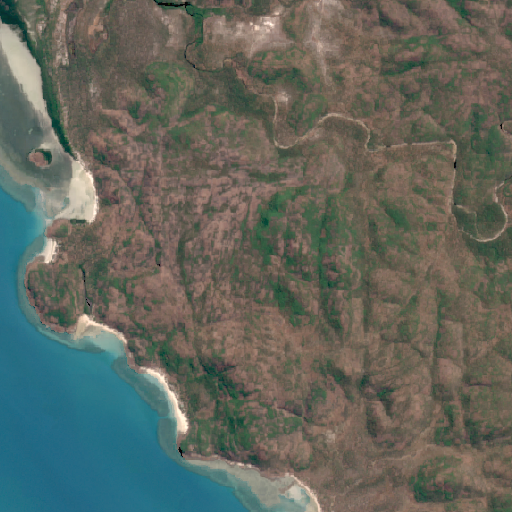

In [ ]:
example = dataset["train"][200]
image = example["image"]
image

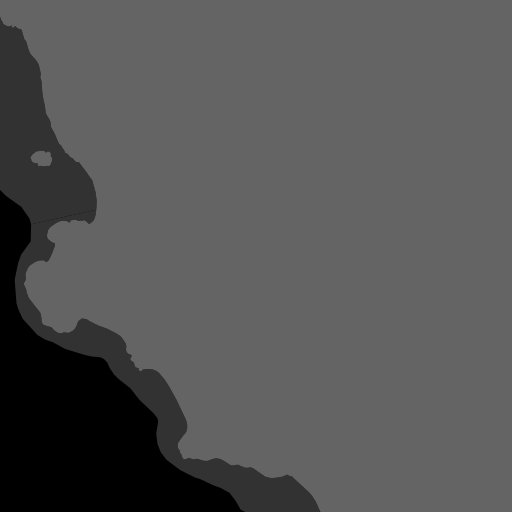

In [ ]:
segmentation_map_img = example["label"]
segmentation_map_img



In case of semantic segmentation, every pixel is labeled with a certain class. 0 is the "background" class.

In [ ]:
# This just crashed using too much ram.
def transform(feat_row):
    # Convert the image to a numpy array and remove the alpha channel
    image_array = np.array(feat_row['image'])
    feat_row['image'] = image_array[:,:,:3].tolist()

    # Convert the label to a numpy array, pick the first band and scale
    label_array = np.array(feat_row['label'])
    feat_row['label'] = (label_array[:,:,0] / 50).astype(int).tolist()

    return feat_row

# Apply the transformations to all splits of the dataset
#dataset2 = dataset.map(transform)

In [ ]:
import numpy as np

raw_segmentation_map = np.array(segmentation_map_img)

# extract only one of the RGB channels (e.g., the Red channel)
segmentation_map = (raw_segmentation_map[:,:,0]/50).astype(int)
segmentation_map

array([[2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       [2, 2, 2, ..., 2, 2, 2],
       ...,
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2],
       [0, 0, 0, ..., 2, 2, 2]])

Let's load the mappings between integers and their classes.

In [ ]:
id2label = {
    0: "water",
    1: "reef",
    2: "land",
    3: "sandbank"
}
print(id2label)

{0: 'water', 1: 'reef', 2: 'land', 3: 'sandbank'}


We can visualize the segmentation map on top of the image, like so:

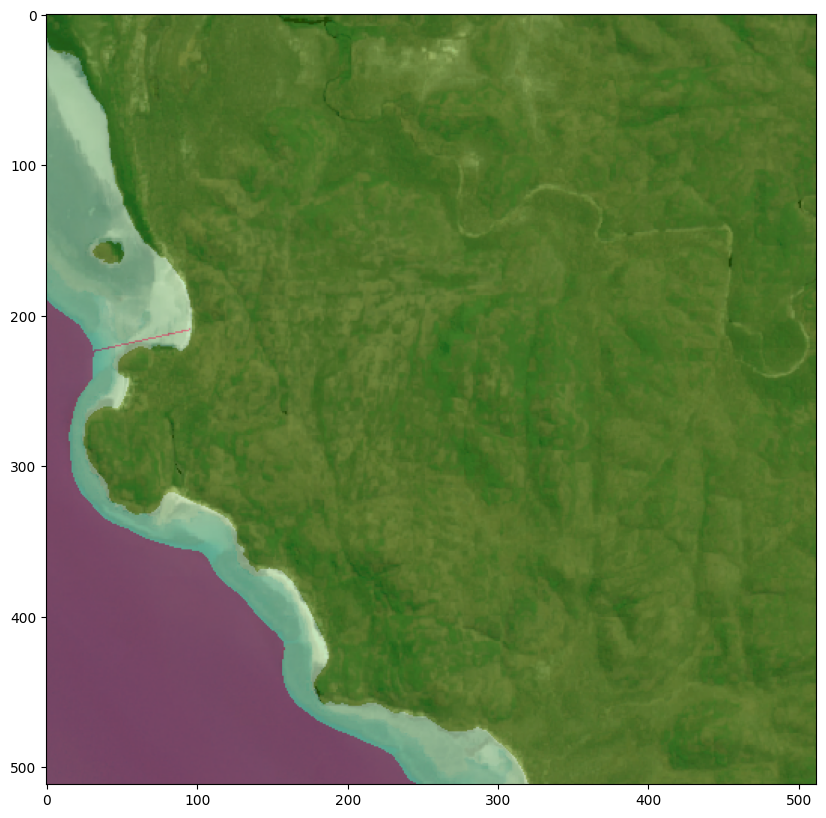

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# map every class to a random color
id2color = {k: list(np.random.choice(range(256), size=3)) for k,v in id2label.items()}

def visualize_map(image, segmentation_map):
    color_seg = np.zeros((segmentation_map.shape[0], segmentation_map.shape[1], 3), dtype=np.uint8) # height, width, 3
    for label, color in id2color.items():
        color_seg[segmentation_map == label, :] = color

    # Remove the alpha channel
    sat_img = np.array(image)[:,:,:3]

    # Show image + mask
    img = sat_img * 0.5 + color_seg * 0.5
    img = img.astype(np.uint8)

    plt.figure(figsize=(15, 10))
    plt.imshow(img)
    plt.show()

visualize_map(image, segmentation_map)

## Create PyTorch dataset

We create a regular PyTorch dataset, which prepares the examples for the model. We augment the training images by random resizing and cropping them to a fixed resolution (448x448), and normalize the color channels. This way, all our training images will have the same fixed resolution. Here we use the [Albumentations](https://albumentations.ai/) library for that purpose, but note that one can also use other libraries like Torchvision or Kornia.

 Note that the model will expect `pixel_values` of shape (batch_size, num_channels, height, width) as input. As Albumentations works on NumPy arrays (which uses a channels-last format), we make sure that the channels are first. The `labels` which the model also expects are of shape (batch_size, height, width) and indicate the ground truth label per pixel, for every example in the batch.

In [ ]:
from torch.utils.data import Dataset
import torch

class SegmentationDataset(Dataset):
  def __init__(self, dataset, transform):
    self.dataset = dataset
    self.transform = transform

  def __len__(self):
    return len(self.dataset)

  def __getitem__(self, idx):
    item = self.dataset[idx]

    # Trim off the alpha channel
    original_image = np.array(item["image"])[:,:,:3]

    # Only keep one channel as they are all the same. Also rescale from 0 - 3
    # instead of the original steps of 50. I don't know if this is necessary, but
    # antialiasing might have creates intermediate values.
    original_segmentation_map = (np.array(item["label"])[:,:,0]/50).astype(int)

    transformed = self.transform(image=original_image, mask=original_segmentation_map)
    image, target = torch.tensor(transformed['image']), torch.LongTensor(transformed['mask'])

    # convert to C, H, W
    image = image.permute(2,0,1)

    return image, target, original_image, original_segmentation_map

Let's create the training and validation datasets (note that we only randomly crop for training images).

In [ ]:
import albumentations as A

# Calculated from https://github.com/aims-ks/transformer-tutorials/blob/main/Calculate_reefscape_normalisation.ipynb
REEFSCAPE_MEAN = np.array([0.1839, 0.3785, 0.4397])
REEFSCAPE_STD = np.array([0.1389, 0.1073, 0.0956])

train_transform = A.Compose([
    # hadded an issue with an image being too small to crop, PadIfNeeded didn't help...
    # if anyone knows why this is happening I'm happy to read why
    # A.PadIfNeeded(min_height=448, min_width=448),
    # A.CenterCrop(height=448, width=448),
    # A.Resize(width=448, height=448),
    A.RandomCrop(height=448, width=448),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.Normalize(mean=REEFSCAPE_MEAN, std=REEFSCAPE_STD),
])

val_transform = A.Compose([
    A.CenterCrop(height=448, width=448),
    #A.Resize(width=448, height=448),
    A.Normalize(mean=REEFSCAPE_MEAN, std=REEFSCAPE_STD),

])

train_dataset = SegmentationDataset(dataset["train"], transform=train_transform)
val_dataset = SegmentationDataset(dataset["validation"], transform=val_transform)

In [ ]:
pixel_values, target, original_image, original_segmentation_map = train_dataset[3]
print(pixel_values.shape)
print(target.shape)

torch.Size([3, 448, 448])
torch.Size([448, 448])


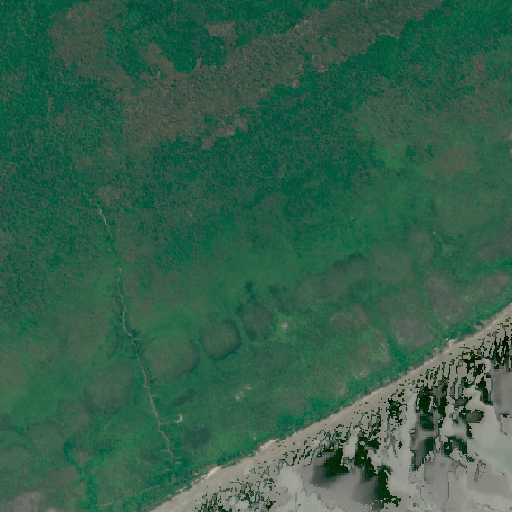

In [ ]:
from PIL import Image

Image.fromarray(original_image)

In [ ]:
[id2label[id] for id in np.unique(original_segmentation_map).tolist()]

['water', 'reef', 'land']

## Create PyTorch dataloaders

Next, we create PyTorch dataloaders, which allow us to get batches of data (as neural networks are trained on batches using stochastic gradient descent or SGD). We just stack the various images and labels along a new batch dimension.

In [ ]:
from torch.utils.data import DataLoader

def collate_fn(inputs):
    batch = dict()
    batch["pixel_values"] = torch.stack([i[0] for i in inputs], dim=0)
    batch["labels"] = torch.stack([i[1] for i in inputs], dim=0)
    batch["original_images"] = [i[2] for i in inputs]
    batch["original_segmentation_maps"] = [i[3] for i in inputs]

    return batch

train_dataloader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn)
val_dataloader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn)

Let's check a batch:

In [ ]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  if isinstance(v,torch.Tensor):
    print(k,v.shape)

pixel_values torch.Size([2, 3, 448, 448])
labels torch.Size([2, 448, 448])


Note that the pixel values are float32 tensors, whereas the labels are long tensors:

In [ ]:
batch["pixel_values"].dtype

torch.float32

In [ ]:
batch["labels"].dtype

torch.int64

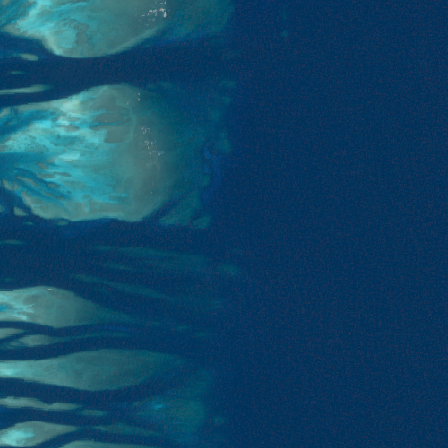

In [ ]:
from PIL import Image

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(REEFSCAPE_STD)[:, None, None]) + np.array(REEFSCAPE_MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
unnormalized_image = Image.fromarray(unnormalized_image)
unnormalized_image

In [ ]:
[id2label[id] for id in torch.unique(batch["labels"][0]).tolist()]

['water', 'reef']

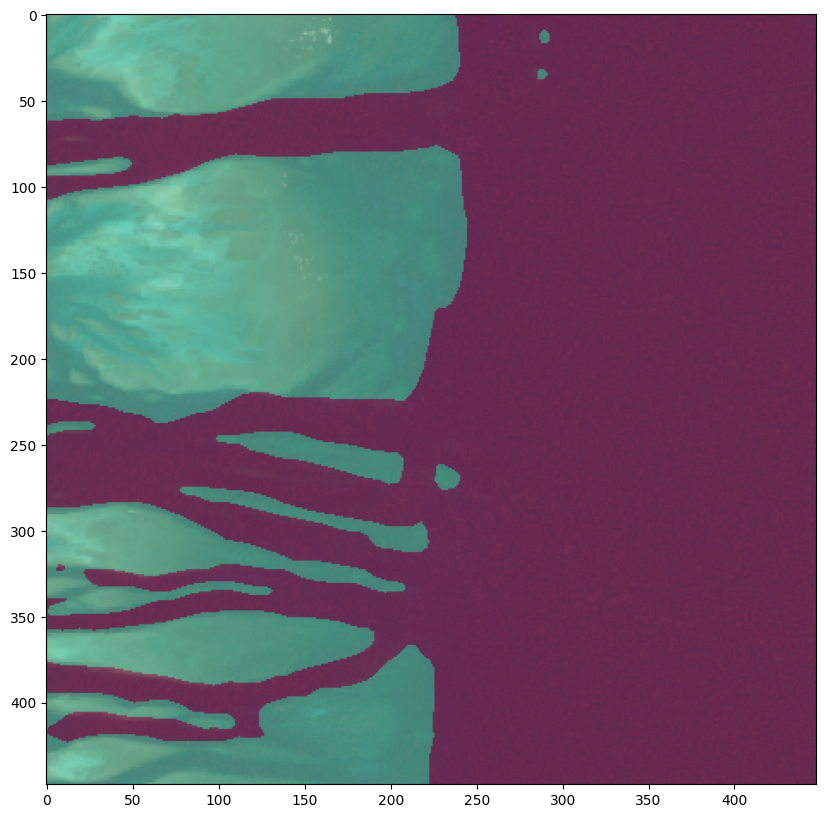

In [ ]:
visualize_map(unnormalized_image, batch["labels"][0].numpy())

## Define model

Next, we define the model, which consists of DINOv2 as backbone + a linear classifier on top. DINOv2 is a regular vision transformer, hence it outputs "patch embeddings", meaning an embedding vector for each image patch. Since we use an image resolution of 448 pixels, and we use a DINOv2 model that has a patch resolution of 14 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L19), we get (448/14)**2 = 1024 patches out. So the model outputs a tensor of shape (batch_size, number of patches, hidden_size) = (batch_size, 1024, 768) for a batch of images (the model has a hidden size - also called embedding dimension - of 768 as seen [here](https://huggingface.co/facebook/dinov2-base/blob/main/config.json#L9)).

Next, we reshape this tensor to become (batch_size, 32, 32, 768), after which we apply the linear layer (below implemented as a Conv2D layer - which is equivalent to a linear transformation when you employ a kernel size of 1x1). This conv2D layer converts the patch embeddings into a logits tensor of shape (batch_size, num_labels, height, width) - which is what we need for semantic segmentation. This tensor contains scores as predicted by the model for all of the classes, for each pixel, for every example in the batch.

In [ ]:
import torch
from transformers import Dinov2Model, Dinov2PreTrainedModel
from transformers.modeling_outputs import SemanticSegmenterOutput


# Model saving/loading path
#model_path = "/content/drive/My Drive/dinov2_segmentation_checkpoint.pth"


class LinearClassifier(torch.nn.Module):
    def __init__(self, in_channels, tokenW=32, tokenH=32, num_labels=1):
        super(LinearClassifier, self).__init__()

        self.in_channels = in_channels
        self.width = tokenW
        self.height = tokenH
        self.classifier = torch.nn.Conv2d(in_channels, num_labels, (1,1))

    def forward(self, embeddings):
        embeddings = embeddings.reshape(-1, self.height, self.width, self.in_channels)
        embeddings = embeddings.permute(0,3,1,2)

        return self.classifier(embeddings)


class Dinov2ForSemanticSegmentation(Dinov2PreTrainedModel):
  def __init__(self, config):
    super().__init__(config)

    self.dinov2 = Dinov2Model(config)
    self.classifier = LinearClassifier(config.hidden_size, 32, 32, config.num_labels)

  def forward(self, pixel_values, output_hidden_states=False, output_attentions=False, labels=None):
    # use frozen features
    outputs = self.dinov2(pixel_values,
                            output_hidden_states=output_hidden_states,
                            output_attentions=output_attentions)
    # get the patch embeddings - so we exclude the CLS token
    patch_embeddings = outputs.last_hidden_state[:,1:,:]

    # convert to logits and upsample to the size of the pixel values
    logits = self.classifier(patch_embeddings)
    logits = torch.nn.functional.interpolate(logits, size=pixel_values.shape[2:], mode="bilinear", align_corners=False)

    loss = None
    if labels is not None:
      # important: we're going to use 0 here as ignore index instead of the default -100
      # as we don't want the model to learn to predict background
      loss_fct = torch.nn.CrossEntropyLoss(ignore_index=0)
      loss = loss_fct(logits.squeeze(), labels.squeeze())

    return SemanticSegmenterOutput(
        loss=loss,
        logits=logits,
        hidden_states=outputs.hidden_states,
        attentions=outputs.attentions,
    )

We can instantiate the model as follows:

In [ ]:
#import os
# 3. Check if the model checkpoint exists in Google Drive
#if os.path.exists(model_path):
    # Load model from checkpoint
#    model = Dinov2ForSemanticSegmentation()
#    model.load_state_dict(torch.load(model_path))
#else:
    # 4. Load the pretrained model
#    model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))


In [ ]:
#model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))

Important: we don't want to train the DINOv2 backbone, only the linear classification head. Hence we don't want to track any gradients for the backbone parameters. This will greatly save us in terms of memory used:

In [ ]:
#for name, param in model.named_parameters():
#  if name.startswith("dinov2"):
#    param.requires_grad = False

Let's perform a forward pass on a random batch, to verify the shape of the logits, verify we can calculate a loss:

In [ ]:
#outputs = model(pixel_values=batch["pixel_values"], labels=batch["labels"])
#print(outputs.logits.shape)
#print(outputs.loss)

As can be seen, the logits are of shape (batch_size, num_labels, height, width). We can then just take the highest logit (score) for each pixel as the model's prediction.

## Train the model

We'll train the model in regular PyTorch fashion. We also use the mIoU (mean Intersection-over-Union) metric to evaluate the performance during training.

Note that I made this entire notebook just for demo purposes, I haven't done any hyperparameter tuning, so feel free to improve. You can also of course use other training frameworks (like the 🤗 Trainer, PyTorch Lightning, 🤗 Accelerate, ...).

In [ ]:
import evaluate

metric = evaluate.load("mean_iou")

In [ ]:
from torch.optim import AdamW
from tqdm.auto import tqdm
import os
from google.colab import drive

# 1. Mount Google Drive
drive.mount('/content/drive')

# 4. Load the pretrained model
model = Dinov2ForSemanticSegmentation.from_pretrained("facebook/dinov2-base", id2label=id2label, num_labels=len(id2label))
for name, param in model.named_parameters():
  if name.startswith("dinov2"):
    param.requires_grad = False

# training hyperparameters
# NOTE: I've just put some random ones here, not optimized at all
# feel free to experiment, see also DINOv2 paper
learning_rate = 5e-5
epochs = 40

#optimizer = AdamW(model.parameters(), lr=learning_rate)
optimizer = AdamW(filter(lambda p: p.requires_grad, model.parameters()), lr=learning_rate)


# Checkpoint saving/loading path
checkpoint_path = "/content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth"


# put model on GPU (set runtime to GPU in Google Colab)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

# Attempt to load saved training state
if os.path.exists(checkpoint_path):
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    start_epoch = checkpoint['epoch']
    print(f"Resuming training from epoch {start_epoch}")
else:
    start_epoch = 0


# put model in training mode
model.train()

# Continue with your training loop
for epoch in range(start_epoch, epochs):
  print("Epoch:", epoch)
  for idx, batch in enumerate(tqdm(train_dataloader)):

      # zero the parameter gradients
      optimizer.zero_grad()

      pixel_values = batch["pixel_values"].to(device)
      labels = batch["labels"].to(device)

      # forward pass
      outputs = model(pixel_values, labels=labels)
      loss = outputs.loss

      loss.backward()
      optimizer.step()



      # evaluate
      with torch.no_grad():
        predicted = outputs.logits.argmax(dim=1)

        # note that the metric expects predictions + labels as numpy arrays
        metric.add_batch(predictions=predicted.detach().cpu().numpy(), references=labels.detach().cpu().numpy())

      # let's print loss and metrics every 100 batches
      if idx % 50 == 0:
        metrics = metric.compute(num_labels=len(id2label),
                                ignore_index=0,
                                reduce_labels=False,
        )

        print("Loss:", loss.item())
        print("Mean_iou:", metrics["mean_iou"])
        print("Mean accuracy:", metrics["mean_accuracy"])
        #... [Metric computation and printout]
        print(f"Saving checkpoint to {checkpoint_path}")
        # Save model, optimizer state, and current epoch
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
        }, checkpoint_path)

Mounted at /content/drive


Some weights of Dinov2ForSemanticSegmentation were not initialized from the model checkpoint at facebook/dinov2-base and are newly initialized: ['classifier.classifier.bias', 'classifier.classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Resuming training from epoch 17
Epoch: 17


  0%|          | 0/386 [00:00<?, ?it/s]

/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:259: RuntimeWarning: invalid value encountered in divide
  iou = total_area_intersect / total_area_union
/root/.cache/huggingface/modules/evaluate_modules/metrics/evaluate-metric--mean_iou/08bc20f4f895f3caf75fb9e3fada1404bded3c3265243d05327cbb3b9326ffe9/mean_iou.py:260: RuntimeWarning: invalid value encountered in divide
  acc = total_area_intersect / total_area_label


Loss: 0.07986177504062653
Mean_iou: 0.9277256967011509
Mean accuracy: 0.9454443390345191
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.13943251967430115
Mean_iou: 0.8677814630318418
Mean accuracy: 0.9268911686309774
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.34861651062965393
Mean_iou: 0.9232960370425952
Mean accuracy: 0.9539746830107013
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.0074326517060399055
Mean_iou: 0.8501237122379782
Mean accuracy: 0.9152065728286051
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.18850140273571014
Mean_iou: 0.8485607665711784
Mean accuracy: 0.925087735738038
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.851540744304657
Mean_iou: 0.8837162491900523
Mean accuracy: 0.9330487432791271
Saving checkpoint

  0%|          | 0/386 [00:00<?, ?it/s]

Loss: 0.26441410183906555
Mean_iou: 0.8815293390492228
Mean accuracy: 0.9144500790712907
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.10411787033081055
Mean_iou: 0.8828894065685944
Mean accuracy: 0.9449051841900854
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.2695600986480713
Mean_iou: 0.8857736719870951
Mean accuracy: 0.9293256779327249
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.1421046257019043
Mean_iou: 0.8726115203677492
Mean accuracy: 0.9276520705989366
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.003050088882446289
Mean_iou: 0.92147763359733
Mean accuracy: 0.9530085445358578
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.040496330708265305
Mean_iou: 0.9351800415871635
Mean accuracy: 0.9622038867177615
Saving checkpoint 

  0%|          | 0/386 [00:00<?, ?it/s]

Loss: 0.04854675009846687
Mean_iou: 0.8818852397074598
Mean accuracy: 0.9329458174901238
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.04806962609291077
Mean_iou: 0.8470011395973707
Mean accuracy: 0.9249958859061952
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.03038536012172699
Mean_iou: 0.9046954498940663
Mean accuracy: 0.9418842458053623
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.9449882507324219
Mean_iou: 0.8710341424249894
Mean accuracy: 0.9117169138893768
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.07228609174489975
Mean_iou: 0.8918561197711729
Mean accuracy: 0.9611105146303247
Saving checkpoint to /content/drive/My Drive/Reefscape/dinov2_segmentation_checkpoint.pth
Loss: 0.3330051302909851
Mean_iou: 0.9410435034003228
Mean accuracy: 0.9673485887770609
Saving checkpoint 

KeyboardInterrupt: ignored

## Training speed

The above training was done in Google Colab on a T4 machine.
## Inference

Once we've trained a model, we can perform inference on new images as follows:

In [ ]:
from PIL import Image

test_image = dataset["validation"][44]["image"]
test_image

In [ ]:
pixel_values = val_transform(image=np.array(test_image)[:,:,:3])["image"]
pixel_values = torch.tensor(pixel_values)
pixel_values = pixel_values.permute(2,0,1).unsqueeze(0) # convert to (batch_size, num_channels, height, width)
# forward pass
with torch.no_grad():
  outputs = model(pixel_values.to(device))
upsampled_logits = torch.nn.functional.interpolate(outputs.logits,
                                                   size=test_image.size[::-1],
                                                   mode="bilinear", align_corners=False)
predicted_map = upsampled_logits.argmax(dim=1)
visualize_map(test_image, predicted_map.squeeze().cpu())

As we can see the model performance after 4 epochs is pretty bad.